<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/hybrid_cnn_with_attention_mechanism_breast_cancer_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis-400x/BY.npy
/kaggle/input/breakhis-400x/BX.npy
/kaggle/input/breasthis-200x/BCY.npy
/kaggle/input/breasthis-200x/BCX.npy


In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model

In [ ]:
X = np.load('/kaggle/input/breakhis-400x/BX.npy')/255
Y = np.load('/kaggle/input/breakhis-400x/BY.npy')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
X.shape

(1693, 128, 128, 3)

In [ ]:
Y.shape

(1693,)

In [ ]:
positional_emb = True
EPOCHS = 100
batch_size = 18
num_classes = 2
learning_rate = 0.0001
weight_decay = 0.0001
image_size = 128
input_shape = (image_size,image_size,3)
#--------------------------------------------
patch_size = 4
filters = 256
depth = 16
kernel_size = 3

In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=1 - train_ratio, random_state=7)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=7)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Multiply

"""def channel_attention(x, ratio=8):
    channel = x.shape[-1]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, channel))(se)

    # Excitation: Bottleneck dense layers
    se = Dense(channel // ratio, activation='relu')(se)
    se = Dense(channel, activation='sigmoid')(se)

    # Scale
    x = Multiply()([x, se])
    return x"""


def channel_attention(input_feature, ratio=8):
    channel = x.shape[-1]

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = layers.Dense(channel // ratio, activation='relu')(avg_pool)
    avg_pool = layers.Dense(channel)(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = layers.Dense(channel // ratio, activation='relu')(max_pool)
    max_pool = layers.Dense(channel)(max_pool)

    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Activation('sigmoid')(attention)

    return layers.Multiply()([x, attention])

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def residual_block_with_attention(x, filters):
    shortcut = x

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Channel attention after convolution
    x = channel_attention(x)

    # Match dimensions if needed
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)

x = residual_block_with_attention(x, 32)
x = MaxPooling2D()(x)

x = residual_block_with_attention(x, 64)
x = MaxPooling2D()(x)

x = residual_block_with_attention(x, 128)
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1, 1, 32)  │          0 │ dense_39[0][0],   │
│                     │                   │            │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 1, 1, 32)  │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 32)               │            │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 128, 128,  │          0 │ multiply_8[0][0], │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 128, 128,  │          0 │ add_17[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ activation_28[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_6[… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 15,386 (60.10 KB)

 Trainable params: 15,322 (59.85 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Compile the final model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate,
                                                     weight_decay=weight_decay),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [ ]:
import time
start = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.4461 - loss: 1.2970 - val_accuracy: 0.6331 - val_loss: 0.6484
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6952 - loss: 0.6207 - val_accuracy: 0.6331 - val_loss: 0.6268
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7270 - loss: 0.5567 - val_accuracy: 0.6331 - val_loss: 0.6019
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7684 - loss: 0.5345 - val_accuracy: 0.6450 - val_loss: 0.5728
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7874 - loss: 0.5255 - val_accuracy: 0.7515 - val_loss: 0.5258
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8057 - loss: 0.4799 - val_accuracy: 0.6864 - val_loss: 0.5175
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8031 - loss: 0.4703 - val_accuracy: 0.7337 - val_loss: 0.4852
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8104 - loss: 0.4579 - val_accuracy: 0.7929 

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9085 - loss: 0.2211


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

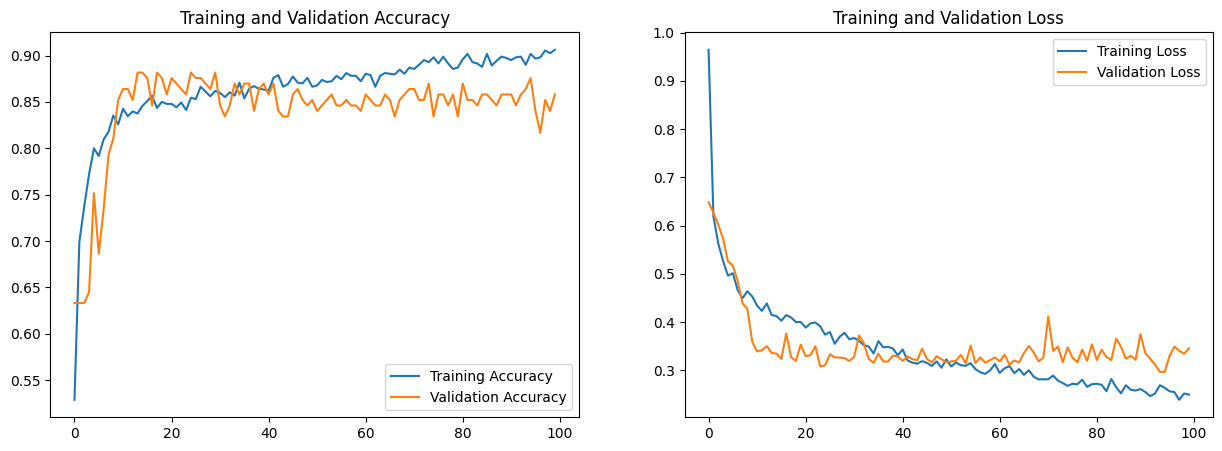

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('accuracy_loss_curve.png', dpi=500)
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_acc = []
fold_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, Y), 1):
    print(f"\n📂 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = Y[train_idx], Y[val_idx]

    model = Model(X.shape[1:], len(np.unique(Y)))

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    scores = model.evaluate(X_val, y_val, verbose=0)
    fold_loss.append(scores[0])
    fold_acc.append(scores[1])

    print(f"Fold {fold} -> Loss: {scores[0]:.4f}, Accuracy: {scores[1]:.4f}")


📂 Fold 1


ValueError: All `inputs` values must be KerasTensors. Received: inputs=(128, 128, 3) including invalid value 128 of type <class 'int'>

In [ ]:
"""
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Multiply, Reshape, Permute, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate

def build_hybrid_attention_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Attention mechanism
    attention = GlobalAveragePooling2D()(x)
    attention = Dense(128, activation='relu')(attention)
    attention = Dense(128, activation='sigmoid')(attention)
    attention = Reshape((1, 1, 128))(attention)
    x = Multiply()([x, attention])

    # Classification head
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model
"""

In [ ]:
"""from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define KFold for 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1s = []

# Perform 10-fold cross-validation
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # Build the model (reset the model for each fold)
    model = Model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the current fold
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation set
    y_pred = model.predict(X_val_fold)
    y_pred_class = np.argmax(y_pred, axis=1)  # For multi-class classification

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_val_fold, y_pred_class)
    precision = precision_score(y_val_fold, y_pred_class, average='weighted')
    recall = recall_score(y_val_fold, y_pred_class, average='weighted')
    f1 = f1_score(y_val_fold, y_pred_class, average='weighted')

    # Append the metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Calculate the mean of each metric
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1s)

# Print the results
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")
"""

In [ ]:
"""from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
import numpy as np

# Assuming X contains image data and y contains labels
# Convert labels to categorical if needed
y_cat = to_categorical(Y)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X, Y):
    print(f'\n🔁 Training for fold {fold_no} ...')

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # Build your model (e.g., hybrid CNN with attention)
    #model = Model()  # Replace with your model-building function

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # Evaluate model
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]:.4f}; {model.metrics_names[1]} = {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

# Summary
print('\n📊 Cross-validation results:')
print(f'Average accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')
print(f'Average loss: {np.mean(loss_per_fold):.4f}')"""